Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Set up data loading functions.

In [2]:
tf.__version__

'2.1.0'

In [42]:
channels = 40
filters = 5
bs = 32

Load data.

In [4]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

with os.scandir('test/') as entries:
    for entry in entries:
        names.append("test/"+entry.name)

In [43]:
def load(name):
    X = []
    Y = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            
            X.append(cX)
            Y.append(cY)
    return [np.array(X), np.array(Y)]

In [6]:
import matplotlib.pyplot as plt

def plot(inp):
    plt.imshow(inp[:, :, 0].reshape(30, 30))
    plt.colorbar()
    plt.show()

Define model.

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((3, 3), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(128, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

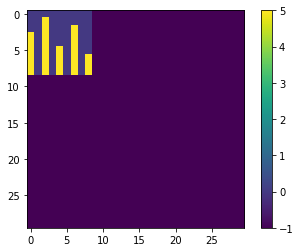

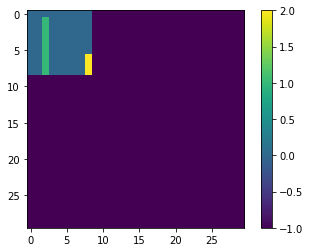

In [55]:
current = 10

ctask = load(names[current])
plot(ctask[0][0])
plot(ctask[1][0])

In [56]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0]-y[:, :, :, 0]))

In [57]:
trainer = tf.keras.optimizers.Adam()

origx = ctask[0]
x = origx.copy()
y = ctask[1]

mask = np.zeros((x.shape[0], 30, 30, channels))
mask[:, :, :, 1] = 1
xl2 = origx*mask

epochs = 500

iterations = 100

for k in range(epochs):
    with tf.GradientTape() as g:
        for i in tf.range(iterations):
            x = model(x)
            x = x*(1-mask)+xl2
        loss = loss_f(x, y)
        grads = g.gradient(loss, model.weights)
        grads = [g/(tf.norm(g)+1e-8) for g in grads]
        trainer.apply_gradients(zip(grads, model.weights))
    if k%5 == 0:
        print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy()))

LOSS AT EPOCH 0: 0.095681936
LOSS AT EPOCH 5: 0.07412127
LOSS AT EPOCH 10: 0.05751105
LOSS AT EPOCH 15: 0.04663617
LOSS AT EPOCH 20: 0.03689253
LOSS AT EPOCH 25: 0.031424485
LOSS AT EPOCH 30: 0.02844853
LOSS AT EPOCH 35: 0.026214099
LOSS AT EPOCH 40: 0.024629366
LOSS AT EPOCH 45: 0.02342484
LOSS AT EPOCH 50: 0.022389106
LOSS AT EPOCH 55: 0.021436088
LOSS AT EPOCH 60: 0.020574065
LOSS AT EPOCH 65: 0.019756652
LOSS AT EPOCH 70: 0.01874634
LOSS AT EPOCH 75: 0.017770719
LOSS AT EPOCH 80: 0.016931392
LOSS AT EPOCH 85: 0.016202593
LOSS AT EPOCH 90: 0.015577007
LOSS AT EPOCH 95: 0.015013012
LOSS AT EPOCH 100: 0.014499944
LOSS AT EPOCH 105: 0.014100904
LOSS AT EPOCH 110: 0.013709378
LOSS AT EPOCH 115: 0.013305365
LOSS AT EPOCH 120: 0.012771231
LOSS AT EPOCH 125: 0.012074884
LOSS AT EPOCH 130: 0.01150899
LOSS AT EPOCH 135: 0.011125491
LOSS AT EPOCH 140: 0.010564372
LOSS AT EPOCH 145: 0.010439439
LOSS AT EPOCH 150: 0.00985827
LOSS AT EPOCH 155: 0.010135518
LOSS AT EPOCH 160: 0.009843189
LOSS AT 

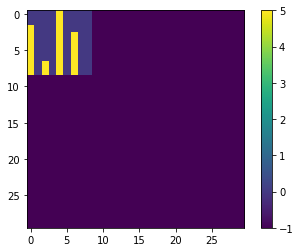

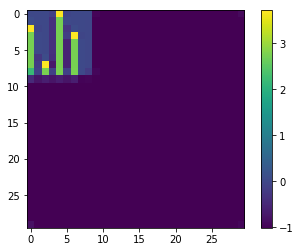

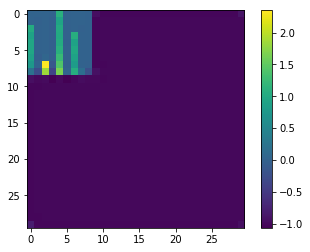

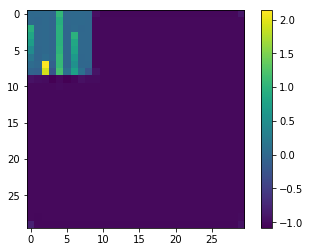

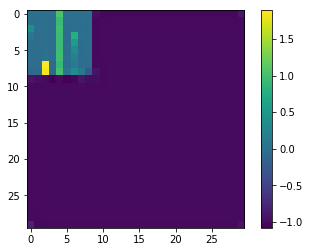

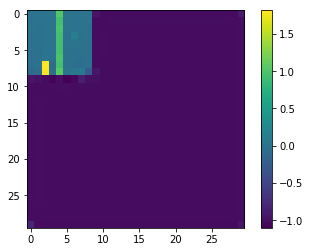

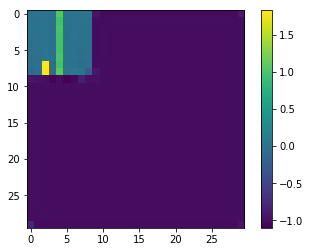

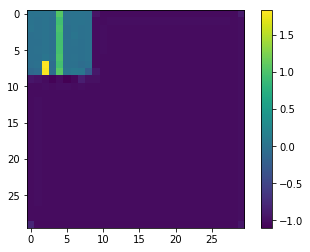

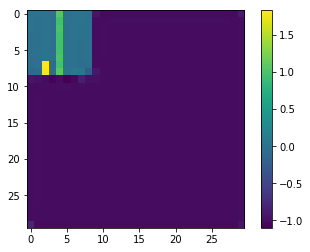

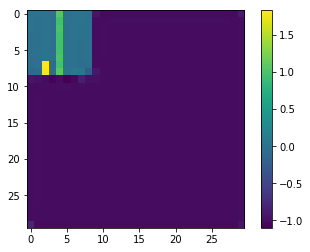

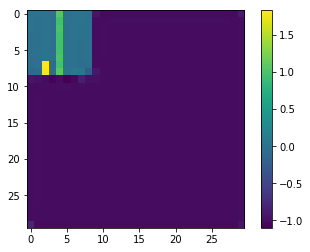

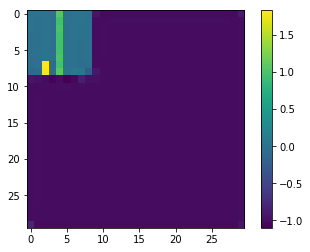

In [60]:
def generate(cin):
    cin = np.array([cin])
    
    mask = np.zeros((1, 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        cin = model(cin)
        cin = cin*(1-mask)+xl2
        if i%10 == 0:
            toprint = cin.numpy()[0]
            plot(toprint)
    
    toprint = cin.numpy()[0]
    plot(toprint)
    return toprint

cin = ctask[0][1]
plot(cin)
out = generate(cin)

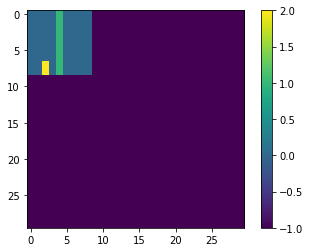

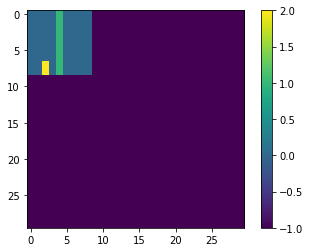

In [62]:
plot(np.clip(np.round(out), -1, 9))
plot(ctask[1][1])